## Goal
The objective of this project is to Build one or more classification models to determine the player using the other columns as features. I will follow data preparation and feature engineering process before I use a classification model to predict the player.

## Load and View the Dataset
I import the necessary libraries:

In [240]:
import pandas as pd #load the data into panda data frames
from sklearn.naive_bayes import GaussianNB #naive bayes model
from sklearn.model_selection import train_test_split #split the dataset
from sklearn import preprocessing #label encoder
from sklearn.metrics import accuracy_score #generate accuracy score
from sklearn.ensemble import RandomForestClassifier #random forest model
from sklearn import tree #decision tree
from wordcloud import WordCloud #generate a word cloud
import matplotlib.pyplot as plt # to plot the word cloud
from matplotlib.pyplot import figure #to resize plot

Then I load Shakespeare plays data sets into the data frames. To understand what the columns meant, I referred to the data source, [Shakespeare plays](https://www.kaggle.com/kingburrito666/shakespeare-plays "Kaggle, Shakespeare Plays Dataset CSV"), which describes the columns as:
- **Dataline:** keeps track of the rows
- **Play:** play that the lines are from
- **PlayLinenumber:** actual line being spoken at any given time
- **ActSceneLine:** Act-Scene-Line from which any given line is from
- **Player:** player who is saying the line
- **PlayerLine:** line being spoken

This is what it looks like:

In [241]:
plays = pd.read_csv('../data/raw/Shakespeare_data.csv')
plays.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


I save the player names in a list to later visualize it as a word cloud.

In [242]:
player_list = plays['Player'].dropna().to_string().replace(" ","").split('\n')

#remove the serial number in the beginning
for index, word in enumerate(player_name):
    player_list[index] = "".join(filter(lambda x: not x.isdigit(), word))

## Data Preparation

### Cleaning
1. Dataline
    - **Remove this column**
    - It seems to just be a serial number
    - Would not serve as a useful feature for the classification model
2. NaN
    - **Drop the rows where the ActSceneLine is NaN**
    - These lines just mention the entrance or exit of characters or sets the scene
    - Cleaning will help prepare statistical summaries of frequencies of a player's lines numbers and ensure *active* dialogs are not influenced by *passive* actions.
    - I choose ActSceneLine instead of PlayerLinenumber as the latter has a value even when it is describing a passive action, whereas the former is line specific and hence more descriptive.
3. PlayerLineNumber
     - Mention the current line being spoken within in act- might not be necessary
     - May **come in handy as a feature to the classification model**

In [243]:
plays = plays.drop(columns=['Dataline'])
plays = plays.dropna(subset=['ActSceneLine'])
plays.head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
3,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
5,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils
6,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.
7,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil


## Feature Engineering

### Extraction
The time stamp example was discussed in class, which encourages to split the date, month and year. Siimilarly, I split the act, scene and line number as their own columns and drop the one combined column.

In [244]:
plays[['Act','Scene', 'Line']] = plays.ActSceneLine.str.split(".",expand=True)
plays = plays.drop(columns=['ActSceneLine'])
plays.head()

,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
3,Henry IV,1.0,KING HENRY IV,"So shaken as we are, so wan with care,",1,1,1
4,Henry IV,1.0,KING HENRY IV,"Find we a time for frighted peace to pant,",1,1,2
5,Henry IV,1.0,KING HENRY IV,And breathe short-winded accents of new broils,1,1,3
6,Henry IV,1.0,KING HENRY IV,To be commenced in strands afar remote.,1,1,4
7,Henry IV,1.0,KING HENRY IV,No more the thirsty entrance of this soil,1,1,5


### Tranformation
To perform statistical analysis and to feed into the classification models, it will be a good idea to encode the strings into integer values as the models do not work with strings.

First, I encode the play names.

In [245]:
play_name_encode = preprocessing.LabelEncoder()
play_name_encode.fit(plays['Play'])
plays['Play'] = play_name_encode.transform(plays['Play'])

Similarly, I encode the lines and player names.

In [246]:
line_encode = preprocessing.LabelEncoder()
line_encode.fit(plays['PlayerLine'])
plays['PlayerLine'] = line_encode.transform(plays['PlayerLine'])

When encoding the player names, I recieved a non-uniform type error as Players has string and floats. So, I first converted the Player column into strings and then encoded.

In [247]:
#convert to string
plays['Player'] = plays['Player'].astype(str)

#encode
player_encode = preprocessing.LabelEncoder()
player_encode.fit(plays['Player'])
plays['Player'] = player_encode.transform(plays['Player'])

After transformation, the data looks like this:

In [248]:
plays.head()

,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
3,9,1.0,457,60241,1,1,1
4,9,1.0,457,23569,1,1,2
5,9,1.0,457,4999,1,1,3
6,9,1.0,457,73794,1,1,4
7,9,1.0,457,48894,1,1,5


## Build Classification Models

### Extraction
First, I mention the player names as the classes that we will be predicting and all the other columns as the features.

In [249]:
classes = plays['Player']
features = plays[['Play', 'PlayerLinenumber', 'PlayerLine','Act','Scene','Line']]

Next, I run the data through the Naive Bayes classifier after splitting the data into test and train subsets with a 20-80 ration.

In [250]:
X_train, X_test, Y_train, Y_test = train_test_split(features, classes, test_size=0.2, random_state=1) 

# training the model on training set 
nb = GaussianNB() 
nb.fit(X_train, Y_train) 
  
# making predictions on the testing set 
nb_predictions = nb.predict(X_test)

# Accuracy
print("\nAccuracy of the Naive Bayes classifier: " + 
      str((accuracy_score(Y_test, nb_predictions)*100).round(5)) + '%')


Accuracy of the Naive Bayes classifier: 18.19695%


The accuracy for Naive Bayes is pretty low, so I try the decision tree clasifier.

In [251]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, Y_train) 
  
# making predictions on the testing set 
dt_predictions = dt.predict(X_test)

# Accuracy
print("\nAccuracy of the decision tree classifier: " + 
      str((accuracy_score(Y_test, dt_predictions)*100).round(5)) + '%')


Accuracy of the decision tree classifier: 71.62284%


I get a pretty good (70-90%) accuracy with the decision tree, so I try the random forest, as it is multiple decision trees put together.

In [252]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(X_train, Y_train)

# making predictions on the testing set 
rf_predictions = rf.predict(X_test)

# Accuracy
print("\nAccuracy of the random forest classifier: " + 
      str((accuracy_score(Y_test, rf_predictions)*100).round(5)) + '%')


Accuracy of the random forest classifier: 74.452%


I achieve the best accuracy using the random forest classifier.

## Visualization

I created a word cloud to visualize the frequency of the lines that each player speaks.

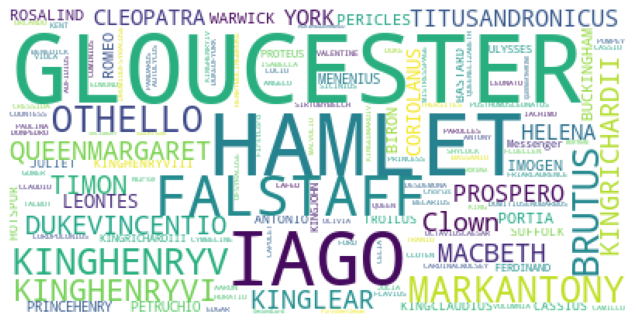

In [253]:
#convert list to string separated by spaces
player_list_text = ' '.join(player_list)

#build word cloud
wordcloud = WordCloud(background_color ='white', collocations=False).generate(player_list_text)

# resize image
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()